# In-class examples

Note that I used a LLM to assemble portions of this notebook.

### Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from urllib.request import urlopen
from scipy import stats
from scipy.ndimage import median_filter
from skimage import data as imData
from skimage.util import random_noise
from scipy.signal import butter, filtfilt

### Global functions

In [3]:
# Let us define a random *generator*
rng = np.random.default_rng()

## Detrending

By modelling a long-term trend, we can remove it from a dataset.

In [4]:
# First, we get some data
# Specifically, a record of CO2 from Mauna Loa
url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.txt"

# Read the data (skip header lines starting with #)
data = []
with urlopen(url) as response:
    for line in response:
        line = line.decode('utf-8').strip()
        if line.startswith('#'):
            continue
        parts = line.split()
        if len(parts) >= 4:
            data.append(parts)

# Convert to DataFrame
df = pd.DataFrame(data, columns=['year', 'month', 'decimal_date', 'average', 'deseasonalized', 'ndays', 'sdev', 'unc'])
df = df.astype({'decimal_date': float, 'average': float})

# Remove missing data (marked as -99.99)
df = df[df['average'] > 0]

# Extract time and CO2 values
time = df['decimal_date'].values
co2 = df['average'].values


Linear fit:
  Slope: 1.6594 ppm/year
  R²: 0.975722

Polynomial fit (degree 2):
  R²: 0.995379


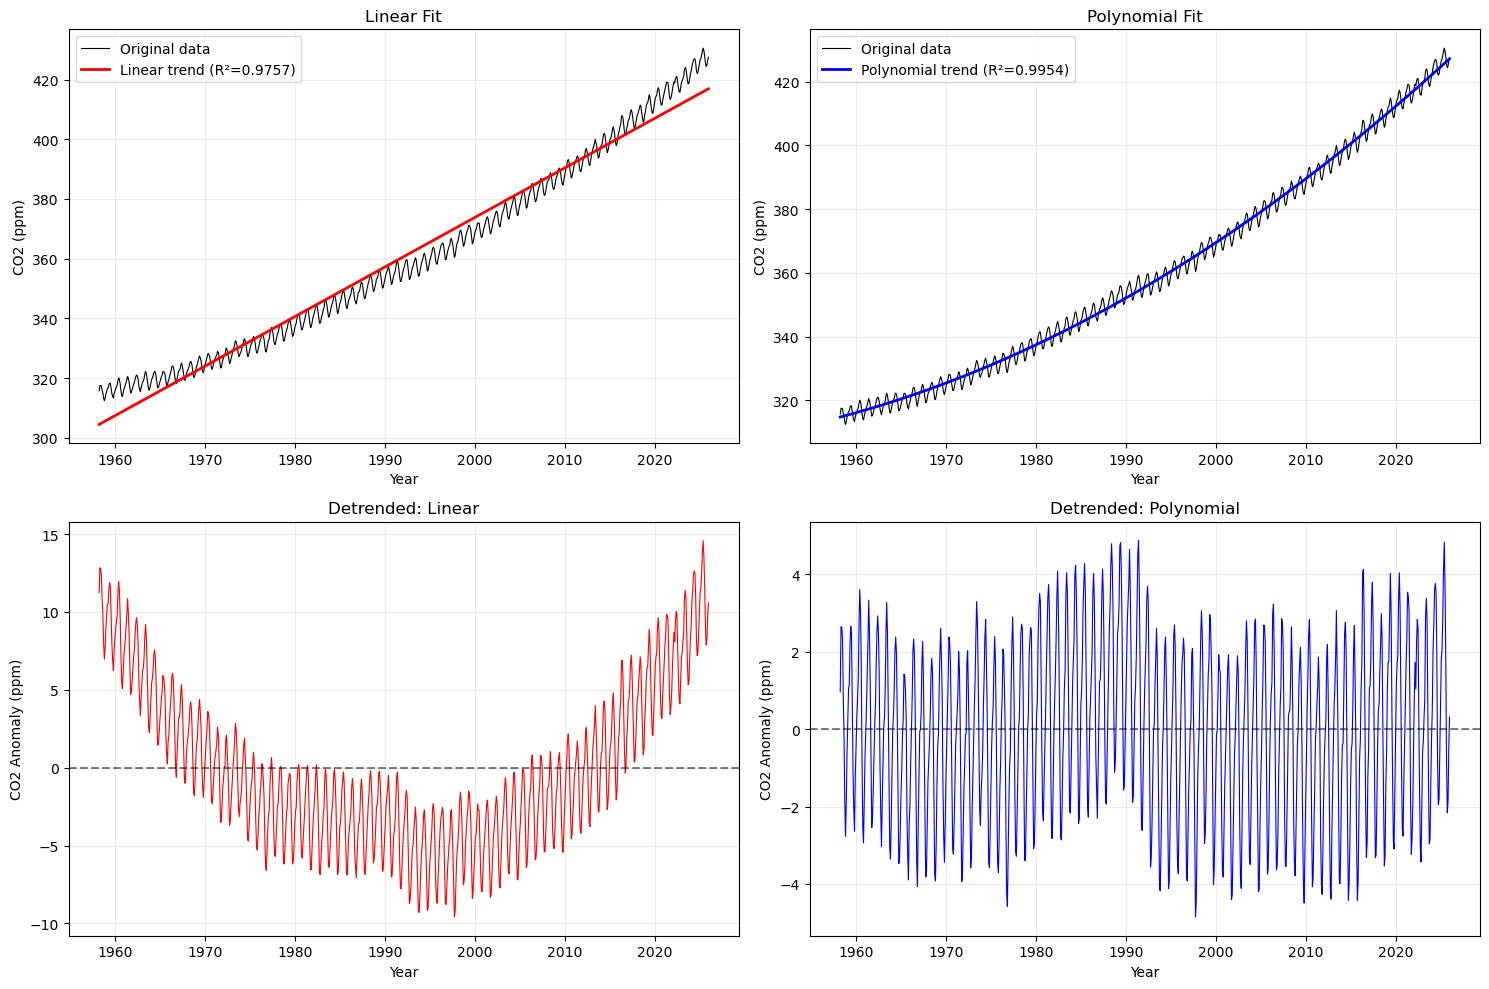

In [6]:
# Now, we attempt to detrend

# Method 1: Linear trend
slope, intercept, r_value, p_value, std_err = stats.linregress(time, co2)
linear_trend = slope * time + intercept

# Method 2: Polynomial fit (degree 2 - quadratic)
poly_coeffs = np.polyfit(time, co2, deg=2)
poly_trend = np.polyval(poly_coeffs, time)

# Calculate detrended data for each method
co2_detrended_linear = co2 - linear_trend
co2_detrended_poly = co2 - poly_trend

# Calculate R² for each method
def r_squared(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

r2_linear = r_squared(co2, linear_trend)
r2_poly = r_squared(co2, poly_trend)

# Print statistics
print(f"\nLinear fit:")
print(f"  Slope: {slope:.4f} ppm/year")
print(f"  R²: {r2_linear:.6f}")
print(f"\nPolynomial fit (degree 2):")
print(f"  R²: {r2_poly:.6f}")

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Top left: Linear fit
axes[0, 0].plot(time, co2, 'k-', linewidth=0.8, label='Original data')
axes[0, 0].plot(time, linear_trend, 'r-', linewidth=2, label=f'Linear trend (R²={r2_linear:.4f})')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('CO2 (ppm)')
axes[0, 0].set_title('Linear Fit')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.25)

# Top right: Polynomial trend only
axes[0, 1].plot(time, co2, 'k-', linewidth=0.8, label='Original data')
axes[0, 1].plot(time, poly_trend, 'b-', linewidth=2, label=f'Polynomial trend (R²={r2_poly:.4f})')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('CO2 (ppm)')
axes[0, 1].set_title('Polynomial Fit')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.25)

# Bottom left: Detrended with linear
axes[1, 0].plot(time, co2_detrended_linear, 'r-', linewidth=0.8)
axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('CO2 Anomaly (ppm)')
axes[1, 0].set_title('Detrended: Linear')
axes[1, 0].grid(True, alpha=0.25)

# Bottom right: Detrended with polynomial
axes[1, 1].plot(time, co2_detrended_poly, 'b-', linewidth=0.8)
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('CO2 Anomaly (ppm)')
axes[1, 1].set_title('Detrended: Polynomial')
axes[1, 1].grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

## Smoothing via median filtering

Original image shape: (512, 512)


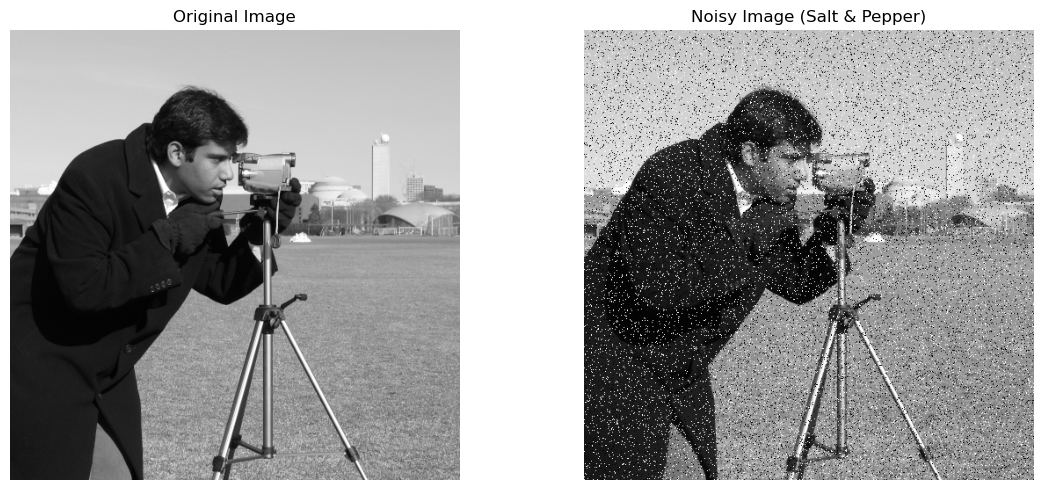

In [7]:
# Load a sample image
img = imData.camera()  # Classic cameraman image
print(f"Original image shape: {img.shape}")

# Add salt-and-pepper noise
noisy_img = random_noise(img, mode='s&p', amount=0.1)
noisy_img = (noisy_img * 255).astype(np.uint8)


# Display results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original image
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Noisy image
axes[1].imshow(noisy_img, cmap='gray')
axes[1].set_title('Noisy Image (Salt & Pepper)')
axes[1].axis('off')

plt.tight_layout()
plt.show()


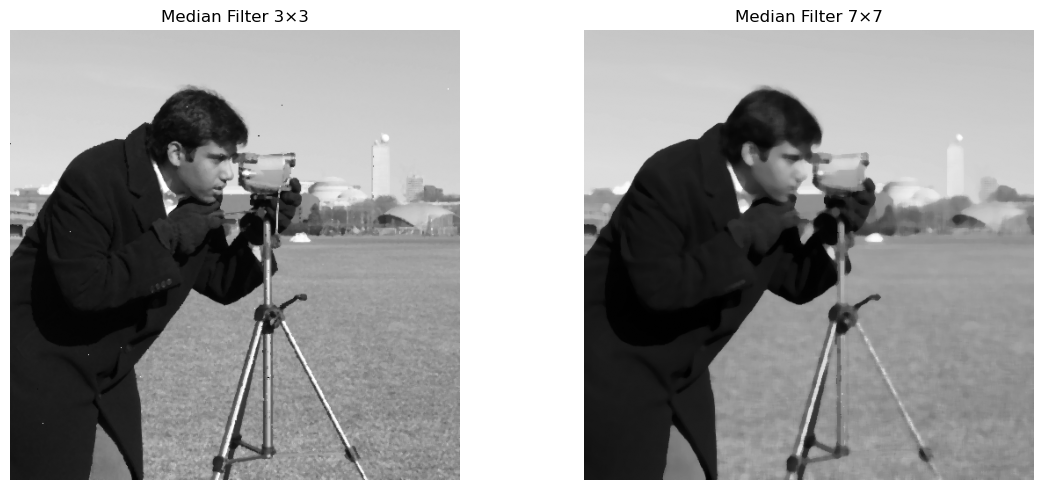

In [8]:

# Apply median filter with different kernel sizes
filtered_3x3 = median_filter(noisy_img, size=3)
filtered_7x7 = median_filter(noisy_img, size=7)


# Display filtered results
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))

# Filtered with 3x3
axes2[0].imshow(filtered_3x3, cmap='gray')
axes2[0].set_title('Median Filter 3×3')
axes2[0].axis('off')

# Filtered with 7x7
axes2[1].imshow(filtered_7x7, cmap='gray')
axes2[1].set_title('Median Filter 7×7')
axes2[1].axis('off')

plt.tight_layout()
plt.show()

## Filtering using frequency

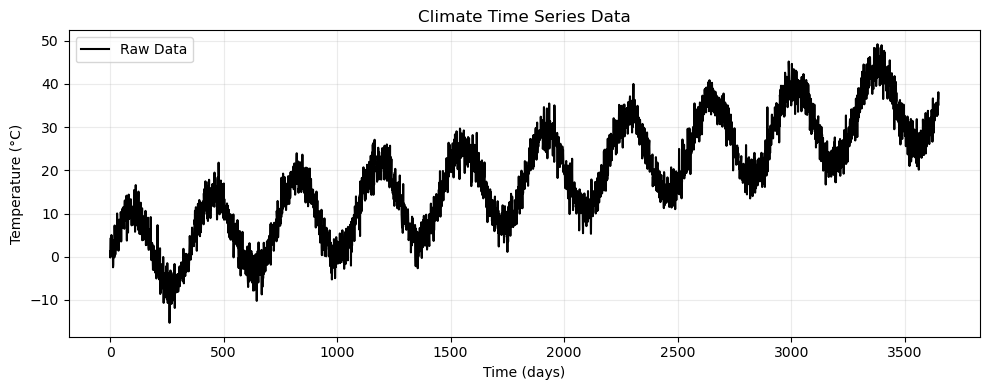

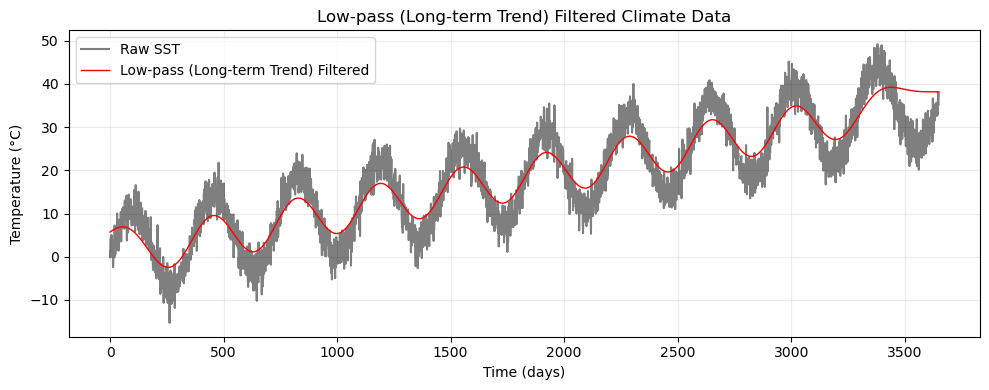

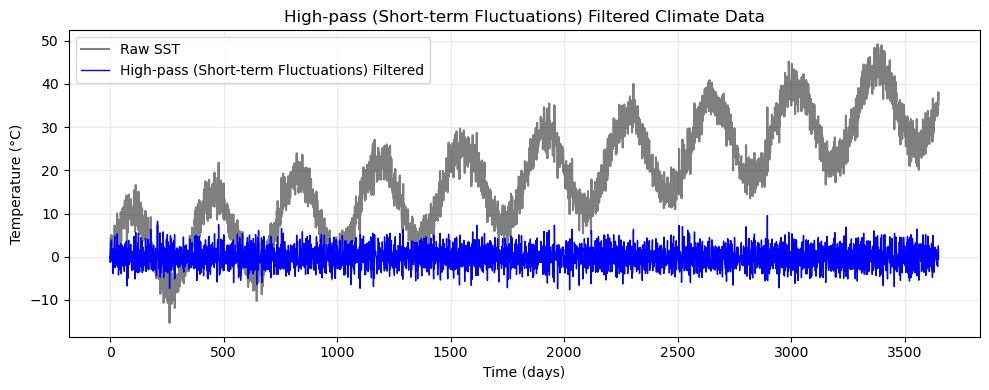

In [9]:
# Configuration
np.random.seed(42)
DAYS = 365 * 10  # 10 years
SAMPLING_FREQ = 1  # samples per day

def generate_sst_data(days):
    """Generate synthetic sea surface temperature data."""
    time = np.arange(0, days, 1)
    trend = 0.01 * time
    seasonal = 10 * np.sin(2 * np.pi * time / 365)
    noise = np.random.normal(0, 0.5, len(time))
    sst = trend + seasonal + 5 * noise
    return time, sst

def butter_filter(cutoff, fs, btype='low', order=5):
    """Create Butterworth filter coefficients."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a

def apply_filter(data, cutoff, fs, btype='low'):
    """Apply Butterworth filter to data."""
    b, a = butter_filter(cutoff, fs, btype)
    return filtfilt(b, a, data)

def plot_comparison(time, raw, filtered, filter_type, color):
    """Plot raw data vs filtered data."""
    plt.figure(figsize=(10, 4))
    plt.plot(time, raw, label='Raw SST', alpha=0.5, color='black')
    plt.plot(time, filtered, label=f'{filter_type} Filtered', color=color, linewidth=1)
    plt.xlabel('Time (days)')
    plt.ylabel('Temperature (°C)')
    plt.title(f'{filter_type} Filtered Climate Data')
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

# Generate data
time, sst = generate_sst_data(DAYS)

# Plot raw data
plt.figure(figsize=(10, 4))
plt.plot(time, sst, label='Raw Data', color='black')
plt.xlabel('Time (days)')
plt.ylabel('Temperature (°C)')
plt.title('Climate Time Series Data')
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Low-pass filter
# Cutoff frequency: 1 cycle per year (1/365), isolates long-term warming trend
sst_lowpass = apply_filter(sst, cutoff=1/365, fs=SAMPLING_FREQ, btype='low')
plot_comparison(time, sst, sst_lowpass, 'Low-pass (Long-term Trend)', 'red')

# High-pass filter
# Cutoff frequency: 1 cycle per month (1/30), isolates short-term variations
sst_highpass = apply_filter(sst, cutoff=1/30, fs=SAMPLING_FREQ, btype='high')
plot_comparison(time, sst, sst_highpass, 'High-pass (Short-term Fluctuations)', 'blue')

## Bootstrapping

In [10]:
# Function(s)

def plot_dist(population, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    else:
        fig = ax.figure
    ax.hist(population, color='black', alpha=1)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.25)
    ax.set_xlim([50, 150])

    mean = np.mean(population)
    std = np.std(population)
    print(f"Mean: {mean:.2f}")
    print(f"Standard deviation: {std:.2f}")

    return ax

Mean: 100.00
Standard deviation: 9.96


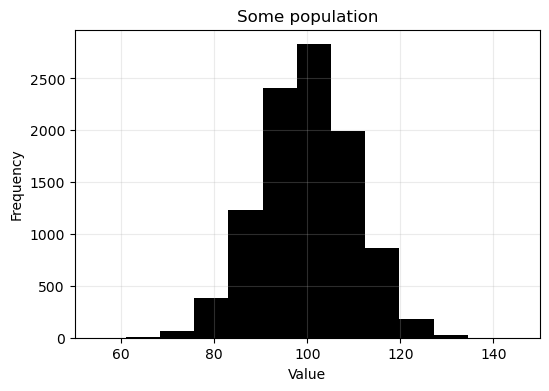

In [11]:
# Generate a normally distributed population of size n
n = 10000
mu = 100    # Mean of the distribution
sigma = 10 # Standard deviation

population = rng.normal(loc=mu, scale=sigma, size=n)

# Example usage:
ax = plot_dist(population)
ax.set_title('Some population');

Mean: 100.40
Standard deviation: 10.17


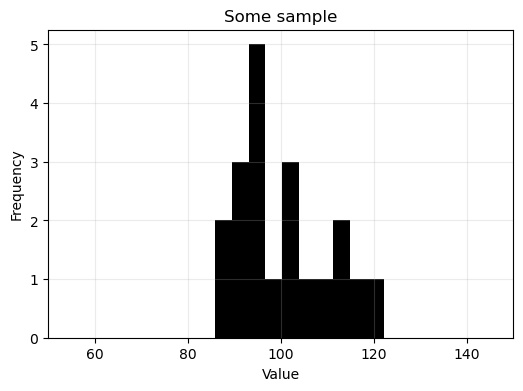

In [12]:
# Now, let's draw 50 random individuals from the true population.
# This dataset represents a "sample".

sample_n = 20
sample = rng.choice(population, size=sample_n, replace=False)

ax = plot_dist(sample)
ax.set_title('Some sample');

Mean: 100.41
Standard deviation: 2.26


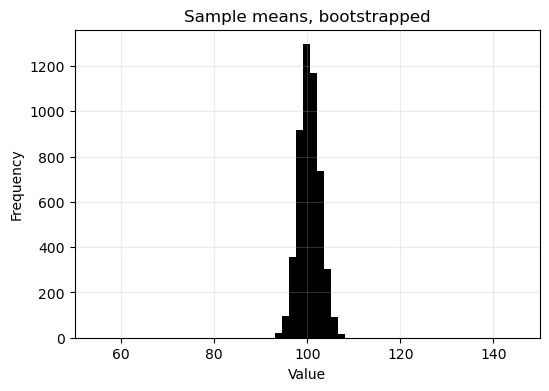

In [13]:
# Now, let's estimate the mean of the true population by bootstrapping our subset

# Number of bootstrap samples
n_bootstrap = 5000

bootstrap_means = []
for _ in range(n_bootstrap):
    bootstrap_sample = rng.choice(sample, size=sample_n, replace=True)
    bootstrap_means.append(np.mean(bootstrap_sample))

ax = plot_dist(bootstrap_means)
ax.set_title('Sample means, bootstrapped');

Mean: 100.41
Standard deviation: 2.26
95% confidence interval for the mean: [96.06, 104.92]


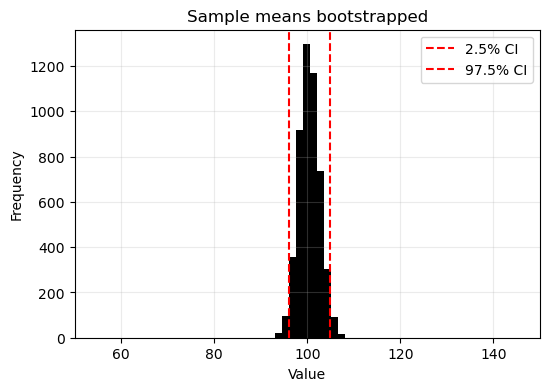

In [14]:
# Let's go ahead and calculate the confidence intervals of our estimate of the mean

lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

ax = plot_dist(bootstrap_means)
ax.set_title('Sample means bootstrapped');
# Add confidence interval bounds to the plot
ax.axvline(lower_bound, color='red', linestyle='--', label='2.5% CI')
ax.axvline(upper_bound, color='red', linestyle='--', label='97.5% CI')
ax.legend()

print(f"95% confidence interval for the mean: [{lower_bound:.2f}, {upper_bound:.2f}]")



Mean: 100.07
Standard deviation: 2.23


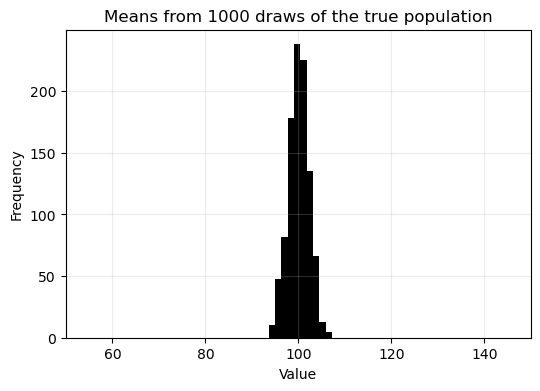

In [15]:
## What if we could actually sample the true population 1000 times?

n_draws = 1000
pop_means = []
for _ in range(n_draws):
    draw = rng.choice(population, size=sample_n, replace=False)
    pop_means.append(np.mean(draw))

ax = plot_dist(pop_means)
ax.set_title('Means from 1000 draws of the true population');

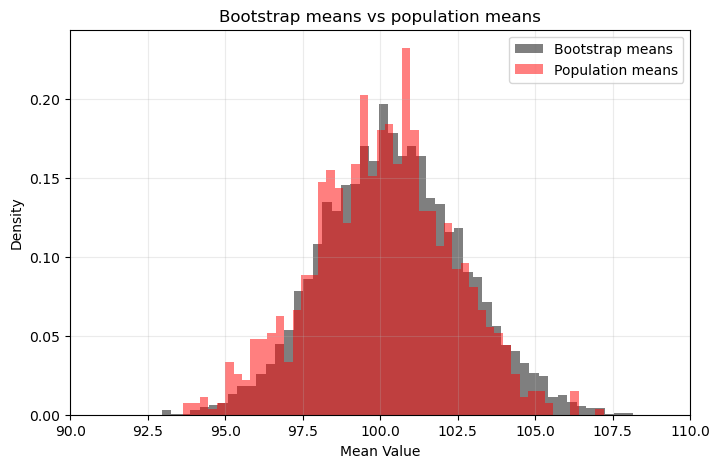

In [16]:
# Let us compare the two distributions of means

plt.figure(figsize=(8, 5))
plt.hist(bootstrap_means, bins=50, alpha=0.5, label='Bootstrap means', color='black', density=True)
plt.hist(pop_means, bins=50, alpha=0.5, label='Population means', color='red', density=True)
plt.xlabel('Mean Value')
plt.ylabel('Density')
plt.title('Bootstrap means vs population means')
plt.legend()
plt.grid(True, alpha=0.25)
plt.xlim([90, 110])
plt.show()

## Monte Carlo methods: an example

Let us say that you have a is a model for $\pi$: 

*The ratio of the area of a unit circle to a unit square is $\pi/4$.*

Given this information, can we calculate a numerical value for $\pi$?

In [17]:
## Functions

def samplePointsInCircle(number_runs, rng):
    """
    Draws number_runs random (x, y) points from a uniform distribution in [-1, 1] x [-1, 1],
    and separates them into points inside the unit circle and all points in the square.

    Returns:
        in_circle: np.ndarray of points inside the circle
        in_square: np.ndarray of all points in the square
    """
    in_circle = np.empty([0, 2])
    in_square = np.empty([0, 2])

    for _ in range(number_runs):
        x = rng.uniform(low=-1, high=1)
        y = rng.uniform(low=-1, high=1)
        origin_dist = x**2 + y**2
        if origin_dist <= 1:
            in_circle = np.append(in_circle, [[x, y]], axis=0)
        in_square = np.append(in_square, [[x, y]], axis=0)
    return in_circle, in_square

## A simple demonstration of the power of sampling 

In [18]:
# We can visualize what we just did
plt.scatter(in_square[:,0], in_square[:,1], marker='x', c='black')
plt.scatter(in_circle[:,0], in_circle[:,1], marker='o', c='red')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Sampling points')
plt.legend(['Points in square', 'Points in circle'], loc='center left', bbox_to_anchor=(1, 0.5))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

NameError: name 'in_square' is not defined

In [ ]:
# Let us estimate pi

pi_est = 4 * (len(in_circle) / len(in_square))
              
print('We estimate the value of pi to be: ' + str(pi_est) + '.')

In [ ]:
# Now, let's see the effect of adding more runs

runs = list(range(50, 10001, 100))

pi_estimates = []

for n in runs:
    in_circle, in_square = samplePointsInCircle(n, rng)
    pi_estimate = 4 * (len(in_circle) / len(in_square))
    pi_estimates.append(pi_estimate)

plt.figure()
plt.plot(runs, pi_estimates, marker='o')
plt.axhline(y=np.pi, color='r', linestyle='--', label='Known value of π')
plt.xlabel('Number of runs')
plt.ylabel('Estimated π')
plt.title('Estimation of π vs Number of Runs')
plt.legend()
plt.show()